### Dataframe setup

In [1]:
import pandas as pd

df = pd.read_csv('./datasets/filtered_data.csv')
df

,patient_id,gender,age,race,ESR1,PGR,ERBB2,subtype
0,TCGA-E2-A1IU,female,60,white,Positive,Positive,Negative,Luminal A
1,TCGA-A2-A04W,female,50,white,Negative,Negative,Positive,HER2-enriched
2,TCGA-A7-A26E,female,71,white,Positive,Positive,Negative,Luminal A
3,TCGA-A8-A07W,female,76,not reported,Positive,Positive,Negative,Luminal A
4,TCGA-D8-A1XY,female,74,white,Positive,Positive,Positive,Luminal B
...,...,...,...,...,...,...,...,...
777,TCGA-D8-A147,female,45,white,Negative,Negative,Negative,Triple Negative
778,TCGA-B6-A40C,female,51,white,Positive,Positive,Negative,Luminal A
779,TCGA-A2-A0CP,female,60,white,Positive,Positive,Negative,Luminal A
780,TCGA-A2-A3XZ,female,46,black or african american,Negative,Negative,Positive,HER2-enriched


### Preprocessing

In [ ]:
from sklearn.preprocessing import LabelEncoder

df = df.drop(columns=['patient_id'])

categorical_cols = ['gender', 'race', 'ESR1', 'PGR', 'ERBB2']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder if needed later


# Encode the target variable (subtype)
target_encoder = LabelEncoder()
df['subtype_encoded'] = target_encoder.fit_transform(df['subtype'])

# Split features and labels
X = df.drop(columns=['subtype_encoded'])
y = df['subtype_encoded']

### Export Preprocessed Data

In [3]:
df.to_csv('./datasets/preprocessed_data.csv', index=False)

import pickle

with open('./datasets/subtype_encoder.pkl', 'wb') as f:
    pickle.dump(target_encoder, f)

### Load Data

In [4]:
# Load preprocessed data
df = pd.read_csv('./datasets/preprocessed_data.csv')

# Load label encoder
with open('./datasets/subtype_encoder.pkl', 'rb') as f:
    target_encoder = pickle.load(f)

df

,gender,age,race,ESR1,PGR,ERBB2,subtype,subtype_encoded
0,0,60,4,2,1,0,Luminal A,1
1,0,50,4,1,0,1,HER2-enriched,0
2,0,71,4,2,1,0,Luminal A,1
3,0,76,3,2,1,0,Luminal A,1
4,0,74,4,2,1,1,Luminal B,2
...,...,...,...,...,...,...,...,...
777,0,45,4,1,0,0,Triple Negative,3
778,0,51,4,2,1,0,Luminal A,1
779,0,60,4,2,1,0,Luminal A,1
780,0,46,2,1,0,1,HER2-enriched,0


### Train model

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

df = df.drop(columns=['subtype'])
# Split features (X) and target (y)
X = df.drop(columns=['subtype_encoded'])
Y = df['subtype_encoded']

# Split into train/test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize models
rf = RandomForestClassifier(random_state=42)
knn = KNeighborsClassifier()

# Train models
rf.fit(X_train, Y_train)
knn.fit(X_train, Y_train)

# Predict
rf_preds = rf.predict(X_test)
knn_preds = knn.predict(X_test)

# Evaluate
print("=== Random Forest ===")
print(classification_report(Y_test, rf_preds, target_names=target_encoder.classes_))

print("=== K-Nearest Neighbors ===")
print(classification_report(Y_test, knn_preds, target_names=target_encoder.classes_, zero_division=0))

print("=== Training Set Subtype Distribution ===")
print(Y_train.value_counts())

=== Random Forest ===
                 precision    recall  f1-score   support

  HER2-enriched       1.00      1.00      1.00         9
      Luminal A       1.00      1.00      1.00        99
      Luminal B       1.00      1.00      1.00        21
Triple Negative       1.00      1.00      1.00        28

       accuracy                           1.00       157
      macro avg       1.00      1.00      1.00       157
   weighted avg       1.00      1.00      1.00       157

=== K-Nearest Neighbors ===
                 precision    recall  f1-score   support

  HER2-enriched       0.00      0.00      0.00         9
      Luminal A       0.86      0.99      0.92        99
      Luminal B       0.75      0.57      0.65        21
Triple Negative       0.81      0.79      0.80        28

       accuracy                           0.84       157
      macro avg       0.61      0.59      0.59       157
   weighted avg       0.79      0.84      0.81       157

=== Training Set Subtype Distrib

### Cross-Validation and Metrics

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVC (Linear)': SVC(kernel='linear'),
    'SVC (RBF)': SVC(kernel='rbf')
}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
    print(f"{name} - F1 (weighted) CV score: {scores.mean():.4f} (+/- {scores.std():.4f})")

Random Forest - F1 (weighted) CV score: 0.9987 (+/- 0.0025)
K-Nearest Neighbors - F1 (weighted) CV score: 0.7806 (+/- 0.0329)
Logistic Regression - F1 (weighted) CV score: 0.9987 (+/- 0.0025)
SVC (Linear) - F1 (weighted) CV score: 0.9987 (+/- 0.0025)
SVC (RBF) - F1 (weighted) CV score: 0.4342 (+/- 0.0030)


### Hyperparameter Tuning

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
 
# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
 
# Initialize base model
rf = RandomForestClassifier(random_state=42)
 
# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_weighted',
                           n_jobs=-1,
                           verbose=1)
 
# Run the grid search
grid_search.fit(X, y)
 
# Show best results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 (weighted):", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best F1 (weighted): 0.9987440010969422


### Final Prediction

In [8]:
# Final model (already fitted during GridSearchCV)
best_model = grid_search.best_estimator_

# Predict on the full feature set
y_pred = best_model.predict(X)

# Optional: Evaluate how well it fits the entire dataset
from sklearn.metrics import classification_report

print(classification_report(y, y_pred, target_names=target_encoder.classes_))

                 precision    recall  f1-score   support

  HER2-enriched       0.97      1.00      0.99        39
      Luminal A       1.00      1.00      1.00       459
      Luminal B       1.00      0.99      1.00       137
Triple Negative       1.00      1.00      1.00       147

       accuracy                           1.00       782
      macro avg       0.99      1.00      1.00       782
   weighted avg       1.00      1.00      1.00       782



### Feature Importance Plot

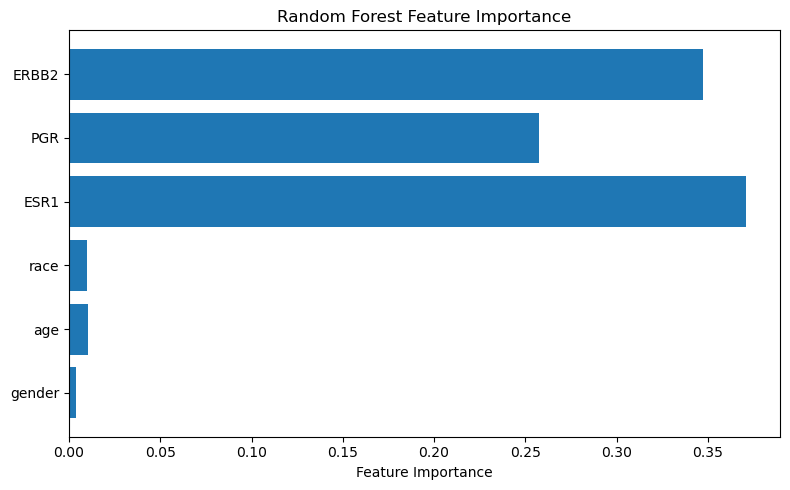

In [9]:
import matplotlib.pyplot as plt

# Get feature importances
importances = best_model.feature_importances_
features = X.columns

# Plot
plt.figure(figsize=(8, 5))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()


### Export Trained Model and Encoders

In [10]:
import pickle

# Save model
with open('./models/trained_rf_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save the subtype encoder
with open('./models/subtype_encoder.pkl', 'wb') as f:
    pickle.dump(target_encoder, f)

# Save feature encoders if needed
with open('./models/feature_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)  # From earlier preprocessing

### Reload model

In [11]:
with open('./models/trained_rf_model.pkl', 'rb') as f:
    model = pickle.load(f)

### Testing

#### Internal Testing

In [12]:
# Predict a few examples (e.g., first 5)
X_test_sample = X.iloc[:5]
y_pred = best_model.predict(X_test_sample)

# Decode predictions
decoded_preds = target_encoder.inverse_transform(y_pred)
print("Sample:", X_test_sample)
print("Predicted subtypes:", decoded_preds)


Sample:    gender  age  race  ESR1  PGR  ERBB2
0       0   60     4     2    1      0
1       0   50     4     1    0      1
2       0   71     4     2    1      0
3       0   76     3     2    1      0
4       0   74     4     2    1      1
Predicted subtypes: ['Luminal A' 'HER2-enriched' 'Luminal A' 'Luminal A' 'Luminal B']


#### External Testing

In [13]:
import pandas as pd
from IPython.display import display

new_patient = pd.DataFrame([{
    'gender': label_encoders['gender'].transform(['female'])[0],
    'age': 55,
    'race': label_encoders['race'].transform(['white'])[0],
    'ESR1': label_encoders['ESR1'].transform(['Positive'])[0],
    'PGR': label_encoders['PGR'].transform(['Positive'])[0],
    'ERBB2': label_encoders['ERBB2'].transform(['Negative'])[0]
}])


# Predict
pred = best_model.predict(new_patient)
pred_label = target_encoder.inverse_transform(pred)
# Combine patient data and prediction into a single DataFrame for display
result = new_patient.copy()
result['Predicted Subtype'] = pred_label

# Display as a table
display(result)

,gender,age,race,ESR1,PGR,ERBB2,Predicted Subtype
0,0,55,4,2,1,0,Luminal A


In [138]:
# Mapping voor subtype
subtype_map = {
    0: 'Luminal A',
    1: 'Luminal B',
    2: 'HER2-enriched',
    3: 'Triple Negative'
}
df['subtype'] = df['subtype_encoded'].map(subtype_map)

# Mapping voor geslacht
gender_map = {0: 'Vrouw', 1: 'Man'}
df['gender_label'] = df['gender'].map(gender_map)

# Mapping voor ESR1-status
esr1_map = {
    2: 'Positief',
    1: 'Negatief'
}

# Mapping voor PGR-status
pgr_map = {
    0: 'Positief',
    1: 'Negatief'
}

# Mapping voor ERBB2-status
erbb2_map = {
    0: 'Positief',
    1: 'Negatief'
}
df

,gender,age,race,ESR1,PGR,ERBB2,subtype_encoded,subtype,gender_label,ESR1_label,PGR_label,ERBB2_label
0,0,60,4,2,1,0,1,Luminal B,Vrouw,Positief,Negatief,Positief
1,0,50,4,1,0,1,0,Luminal A,Vrouw,Negatief,Positief,Negatief
2,0,71,4,2,1,0,1,Luminal B,Vrouw,Positief,Negatief,Positief
3,0,76,3,2,1,0,1,Luminal B,Vrouw,Positief,Negatief,Positief
4,0,74,4,2,1,1,2,HER2-enriched,Vrouw,Positief,Negatief,Negatief
...,...,...,...,...,...,...,...,...,...,...,...,...
777,0,45,4,1,0,0,3,Triple Negative,Vrouw,Negatief,Positief,Positief
778,0,51,4,2,1,0,1,Luminal B,Vrouw,Positief,Negatief,Positief
779,0,60,4,2,1,0,1,Luminal B,Vrouw,Positief,Negatief,Positief
780,0,46,2,1,0,1,0,Luminal A,Vrouw,Negatief,Positief,Negatief


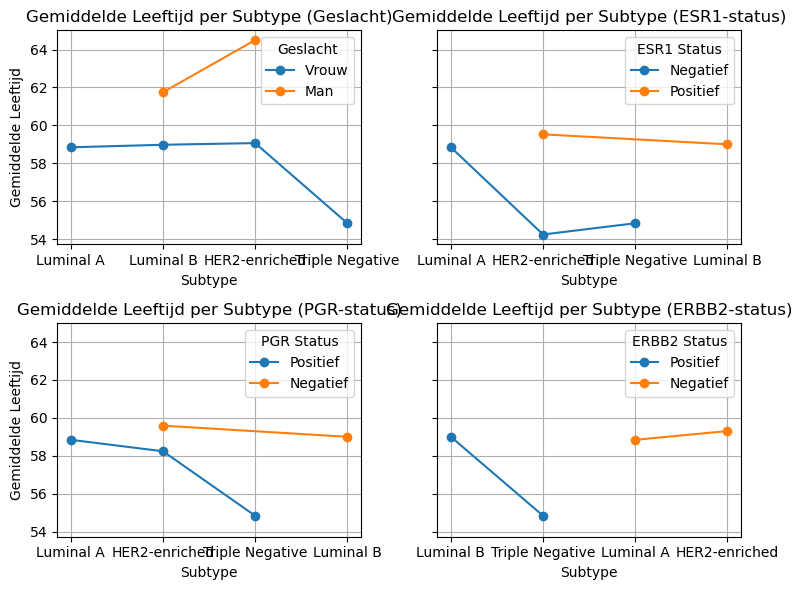

In [139]:
# Subtype volgorde definiëren
subtype_order = ['Luminal A', 'Luminal B', 'HER2-enriched', 'Triple Negative']

# Groeperingen maken
grouped_gender = df.groupby(['subtype', 'gender_label'])['age'].mean().reset_index()
grouped_gender['subtype'] = pd.Categorical(grouped_gender['subtype'], categories=subtype_order, ordered=True)
grouped_gender = grouped_gender.sort_values('subtype')

grouped_esr1 = df.groupby(['ESR1', 'subtype'])['age'].mean().reset_index()
grouped_esr1['subtype'] = pd.Categorical(grouped_esr1['subtype'], categories=subtype_order, ordered=True)
grouped_esr1 = grouped_esr1.sort_values('subtype')

grouped_pgr = df.groupby(['PGR', 'subtype'])['age'].mean().reset_index()
grouped_pgr['subtype'] = pd.Categorical(grouped_pgr['subtype'], categories=subtype_order, ordered=True)
grouped_pgr = grouped_pgr.sort_values('subtype')

grouped_erbb2 = df.groupby(['ERBB2', 'subtype'])['age'].mean().reset_index()
grouped_erbb2['subtype'] = pd.Categorical(grouped_erbb2['subtype'], categories=subtype_order, ordered=True)
grouped_erbb2 = grouped_erbb2.sort_values('subtype')

# Maak 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharey=True)

# Plot 1: per geslacht
for gender in grouped_gender['gender_label'].unique():
    subset = grouped_gender[grouped_gender['gender_label'] == gender]
    axs[0, 0].plot(
        subset['subtype'],
        subset['age'],
        marker='o',
        label=gender
    )
axs[0, 0].set_title('Gemiddelde Leeftijd per Subtype (Geslacht)')
axs[0, 0].set_xlabel('Subtype')
axs[0, 0].set_ylabel('Gemiddelde Leeftijd')
axs[0, 0].grid(True)
axs[0, 0].legend(title='Geslacht')

# Plot 2: per ESR1
for esr1 in sorted(grouped_esr1['ESR1'].unique()):
    if esr1 not in esr1_map:
        continue
    subset = grouped_esr1[grouped_esr1['ESR1'] == esr1]
    axs[0, 1].plot(
        subset['subtype'],
        subset['age'],
        marker='o',
        label=esr1_map[esr1]
    )
axs[0, 1].set_title('Gemiddelde Leeftijd per Subtype (ESR1-status)')
axs[0, 1].set_xlabel('Subtype')
axs[0, 1].grid(True)
axs[0, 1].legend(title='ESR1 Status')

# Plot 3: per PGR
for pgr in sorted(grouped_pgr['PGR'].unique()):
    if pgr not in pgr_map:
        continue
    subset = grouped_pgr[grouped_pgr['PGR'] == pgr]
    axs[1, 0].plot(
        subset['subtype'],
        subset['age'],
        marker='o',
        label=pgr_map[pgr]
    )
axs[1, 0].set_title('Gemiddelde Leeftijd per Subtype (PGR-status)')
axs[1, 0].set_xlabel('Subtype')
axs[1, 0].set_ylabel('Gemiddelde Leeftijd')
axs[1, 0].grid(True)
axs[1, 0].legend(title='PGR Status')

# Plot 4: per ERBB2
for erbb2 in sorted(grouped_erbb2['ERBB2'].unique()):
    if erbb2 not in erbb2_map:
        continue
    subset = grouped_erbb2[grouped_erbb2['ERBB2'] == erbb2]
    axs[1, 1].plot(
        subset['subtype'],
        subset['age'],
        marker='o',
        label=erbb2_map[erbb2]
    )
axs[1, 1].set_title('Gemiddelde Leeftijd per Subtype (ERBB2-status)')
axs[1, 1].set_xlabel('Subtype')
axs[1, 1].grid(True)
axs[1, 1].legend(title='ERBB2 Status')

plt.tight_layout()
plt.show()

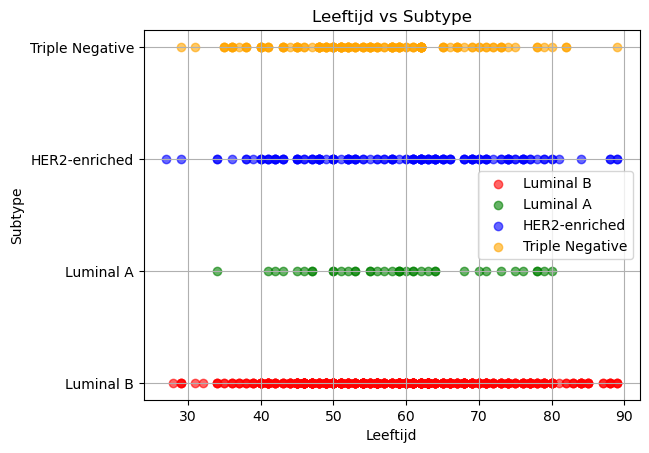

In [140]:
# Unieke subtypes en kleuren toewijzen
subtypes = df['subtype'].unique()
colors = ['red', 'green', 'blue', 'orange']  # of breid uit als nodig

# Plot per subtype
for i, subtype in enumerate(subtypes):
    subset = df[df['subtype'] == subtype]
    plt.scatter(subset['age'], [i]*len(subset), color=colors[i], alpha=0.6, label=subtype)

plt.xlabel('Leeftijd')
plt.yticks(range(len(subtypes)), subtypes)  # Zorgt dat de y-as labels de namen tonen
plt.ylabel('Subtype')
plt.title('Leeftijd vs Subtype')
plt.legend()
plt.grid(True)
plt.show()


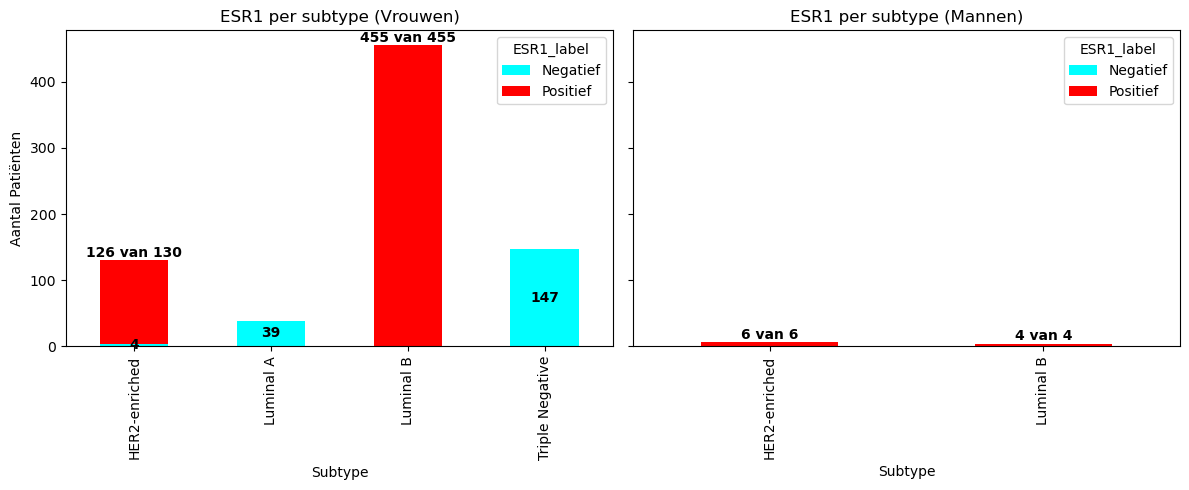

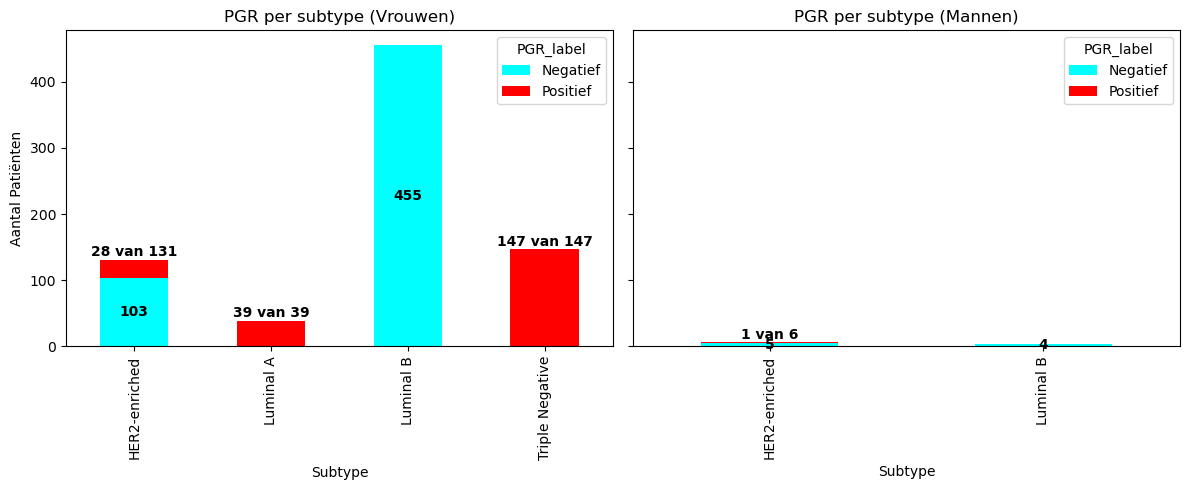

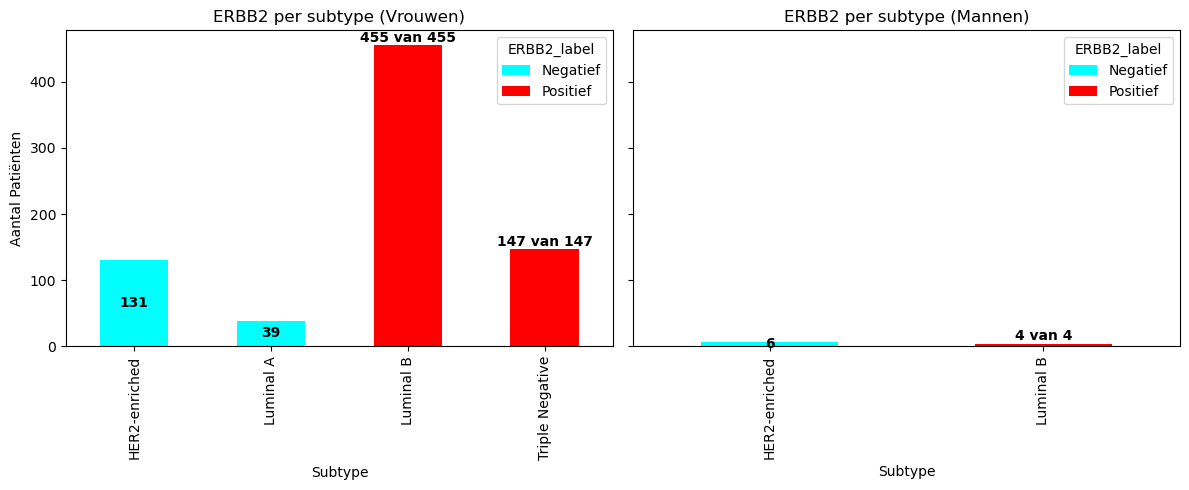

In [171]:
def plot_biomarker_distribution_with_labels(biomarker_label_col, biomarker_name, colors):
    grouped = df.groupby(['subtype', 'gender_label', biomarker_label_col]).size().unstack(fill_value=0)

    # Verdeel in vrouwen en mannen
    vrouw_df = grouped.xs('Vrouw', level='gender_label')
    man_df = grouped.xs('Man', level='gender_label')

    # Subplots maken
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    for data, ax, title in zip([vrouw_df, man_df], axes, ['Vrouwen', 'Mannen']):
        bars = data.plot(kind='bar', stacked=True, color=colors, ax=ax)
        ax.set_title(f'{biomarker_name} per subtype ({title})')
        ax.set_xlabel('Subtype')
        ax.set_ylabel('Aantal Patiënten')

        for i, subtype in enumerate(data.index):
            total = data.loc[subtype].sum()
            y_offset = 0

            for j, label in enumerate(data.columns):
                value = data.loc[subtype, label]
                if value > 0:
                    if j == 0:
                        # Onderste waarde → midden in de staaf
                        ax.text(i, y_offset + value / 2, f"{value}", ha='center', va='center', fontweight='bold')
                    elif j == 1:
                        # Bovenste waarde → boven de hele staaf
                        ax.text(i, total + 0.5, f"{value} van {total}", ha='center', va='bottom', fontweight='bold')
                    y_offset += value

    plt.tight_layout()
    plt.show()

# Gebruik voor alle drie biomarkers
plot_biomarker_distribution_with_labels('ESR1_label', 'ESR1', ['cyan', 'red'])
plot_biomarker_distribution_with_labels('PGR_label', 'PGR', ['cyan', 'red'])
plot_biomarker_distribution_with_labels('ERBB2_label', 'ERBB2', ['cyan', 'red'])

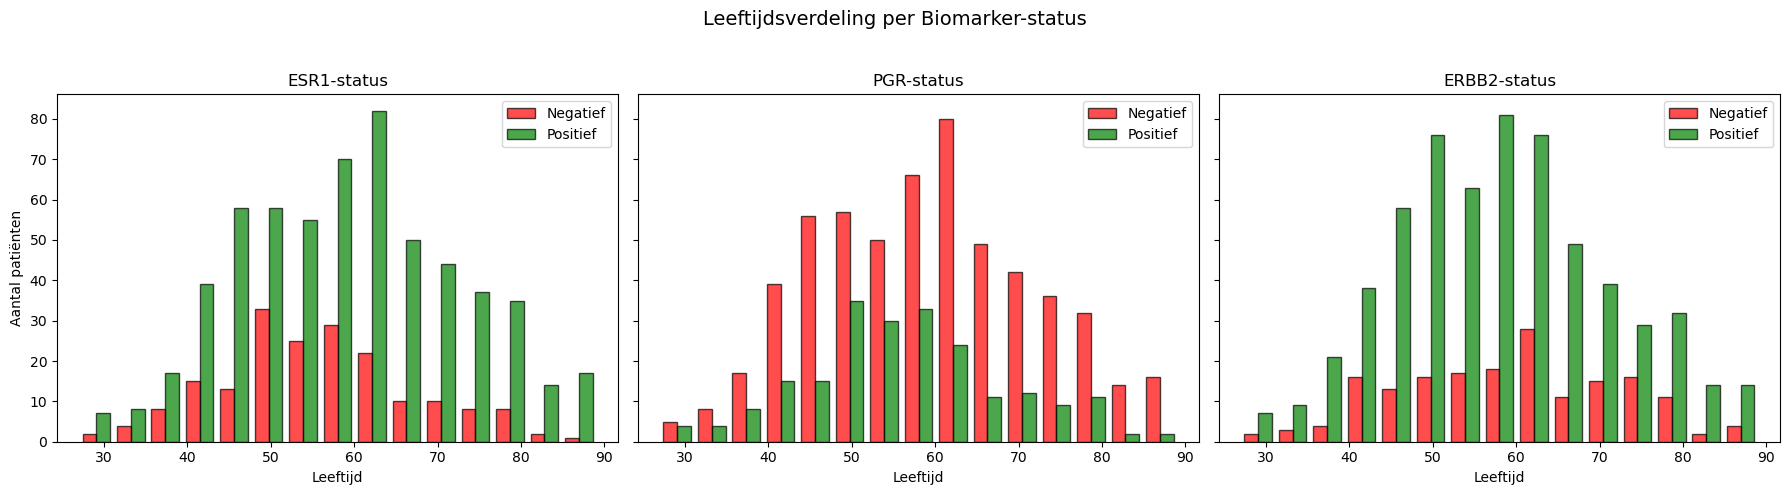

In [172]:
# Zorg dat labels correct zijn
df['ESR1_label'] = df['ESR1'].map({1: 'Negatief', 2: 'Positief'})
df['PGR_label'] = df['PGR'].map({0: 'Positief', 1: 'Negatief'})
df['ERBB2_label'] = df['ERBB2'].map({0: 'Positief', 1: 'Negatief'})

# Subplot setup
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Plot ESR1
axs[0].hist(
    [df[df['ESR1_label'] == 'Negatief']['age'], df[df['ESR1_label'] == 'Positief']['age']],
    bins=15, color=['red', 'green'], label=['Negatief', 'Positief'],
    edgecolor='black', alpha=0.7
)
axs[0].set_title('ESR1-status')
axs[0].set_xlabel('Leeftijd')
axs[0].set_ylabel('Aantal patiënten')
axs[0].legend()

# Plot PGR
axs[1].hist(
    [df[df['PGR_label'] == 'Negatief']['age'], df[df['PGR_label'] == 'Positief']['age']],
    bins=15, color=['red', 'green'], label=['Negatief', 'Positief'],
    edgecolor='black', alpha=0.7
)
axs[1].set_title('PGR-status')
axs[1].set_xlabel('Leeftijd')
axs[1].legend()

# Plot ERBB2
axs[2].hist(
    [df[df['ERBB2_label'] == 'Negatief']['age'], df[df['ERBB2_label'] == 'Positief']['age']],
    bins=15, color=['red', 'green'], label=['Negatief', 'Positief'],
    edgecolor='black', alpha=0.7
)
axs[2].set_title('ERBB2-status')
axs[2].set_xlabel('Leeftijd')
axs[2].legend()

# Final layout
plt.suptitle('Leeftijdsverdeling per Biomarker-status', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

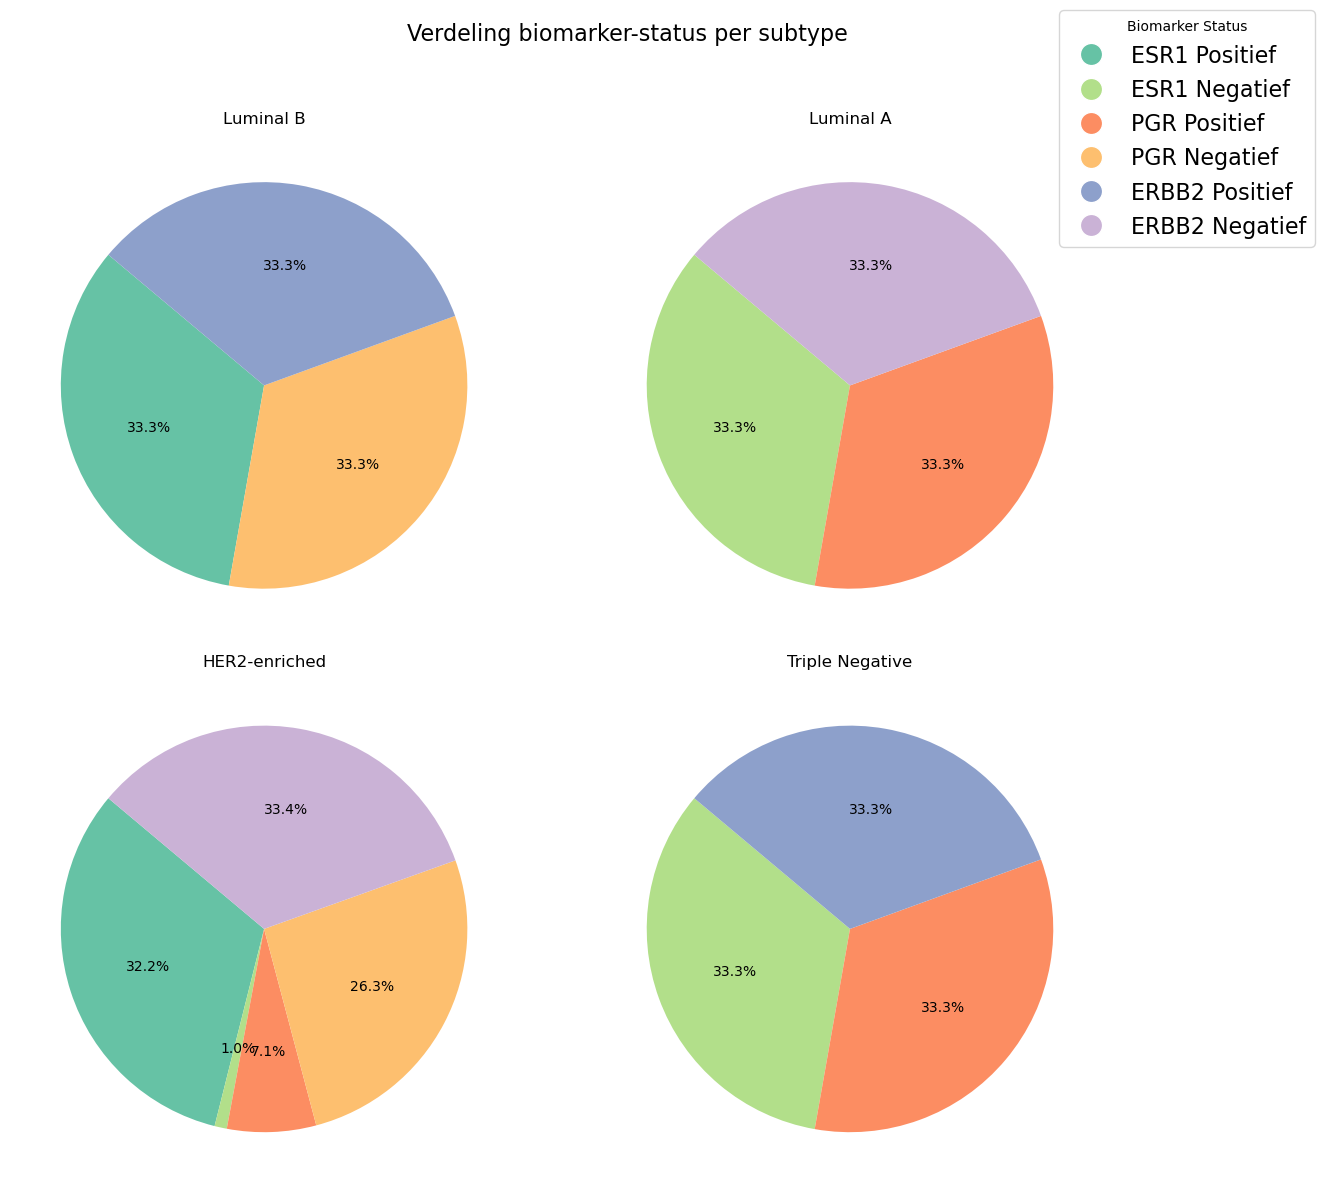

In [173]:

colors = {
    'ESR1_Pos': '#66c2a5',
    'ESR1_Neg': '#b2df8a',
    'PGR_Pos': '#fc8d62',
    'PGR_Neg': '#fdbf6f',
    'ERBB2_Pos': '#8da0cb',
    'ERBB2_Neg': '#cab2d6'
}

subtypes = df['subtype'].unique()
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, subtype in enumerate(subtypes):
    sub_df = df[df['subtype'] == subtype]

    esr_pos = (sub_df['ESR1_label'] == 'Positief').sum()
    esr_neg = (sub_df['ESR1_label'] == 'Negatief').sum()
    pgr_pos = (sub_df['PGR_label'] == 'Positief').sum()
    pgr_neg = (sub_df['PGR_label'] == 'Negatief').sum()
    erb_pos = (sub_df['ERBB2_label'] == 'Positief').sum()
    erb_neg = (sub_df['ERBB2_label'] == 'Negatief').sum()

    values = [esr_pos, esr_neg, pgr_pos, pgr_neg, erb_pos, erb_neg]
    pie_colors = [
        colors['ESR1_Pos'], colors['ESR1_Neg'],
        colors['PGR_Pos'], colors['PGR_Neg'],
        colors['ERBB2_Pos'], colors['ERBB2_Neg']
    ]

    # Pie chart zonder labels, alleen autopct (percentage)
    axes[i].pie(values, colors=pie_colors,
                autopct=lambda pct: ('%1.1f%%' % pct) if pct > 0 else '',
                startangle=140)
    axes[i].set_title(f"{subtype}")

# Maak één legenda voor de hele figuur
labels_legend = [
    'ESR1 Positief', 'ESR1 Negatief',
    'PGR Positief', 'PGR Negatief',
    'ERBB2 Positief', 'ERBB2 Negatief'
]
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                      markerfacecolor=color, markersize=16) 
           for label, color in zip(labels_legend, pie_colors)]
fig.legend(handles=handles, loc='upper right', title="Biomarker Status", fontsize=16)

plt.suptitle('Verdeling biomarker-status per subtype', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


C:\Users\Roderick\AppData\Local\Temp\ipykernel_7096\574460367.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='subtype', y='age', data=df, palette='Set3', ax=axes[0, 0])


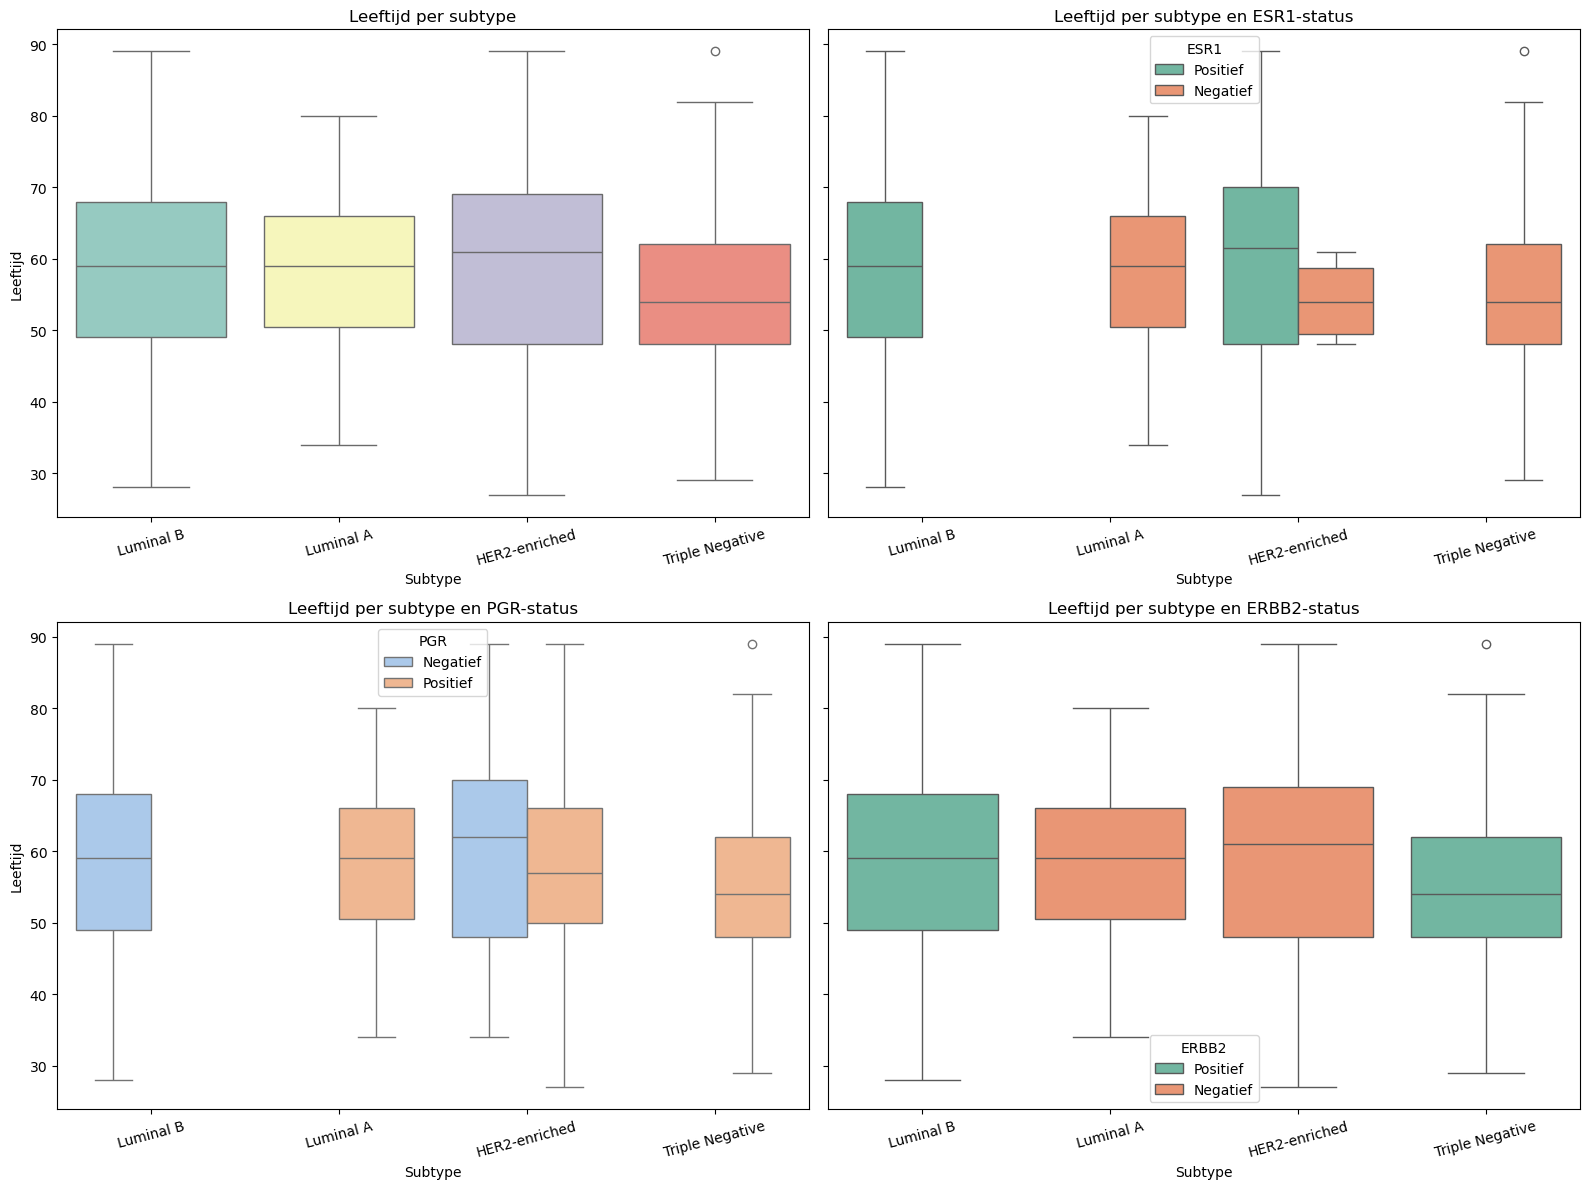

In [174]:
import seaborn as sns

# Subplots: 2 rijen, 2 kolommen (figuur 1 + 3 biomarkers)
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)

# 1. Leeftijd per subtype (zonder biomarker)
sns.boxplot(x='subtype', y='age', data=df, palette='Set3', ax=axes[0, 0])
axes[0, 0].set_title('Leeftijd per subtype')
axes[0, 0].set_xlabel('Subtype')
axes[0, 0].set_ylabel('Leeftijd')
axes[0, 0].tick_params(axis='x', rotation=15)

# 2. Leeftijd + ESR1
sns.boxplot(x='subtype', y='age', hue='ESR1_label', data=df, palette='Set2', ax=axes[0, 1])
axes[0, 1].set_title('Leeftijd per subtype en ESR1-status')
axes[0, 1].set_xlabel('Subtype')
axes[0, 1].set_ylabel('')
axes[0, 1].tick_params(axis='x', rotation=15)
axes[0, 1].legend(title='ESR1')

# 3. Leeftijd + PGR
sns.boxplot(x='subtype', y='age', hue='PGR_label', data=df, palette='pastel', ax=axes[1, 0])
axes[1, 0].set_title('Leeftijd per subtype en PGR-status')
axes[1, 0].set_xlabel('Subtype')
axes[1, 0].set_ylabel('Leeftijd')
axes[1, 0].tick_params(axis='x', rotation=15)
axes[1, 0].legend(title='PGR')

# 4. Leeftijd + ERBB2
sns.boxplot(x='subtype', y='age', hue='ERBB2_label', data=df, palette='Set2', ax=axes[1, 1])
axes[1, 1].set_title('Leeftijd per subtype en ERBB2-status')
axes[1, 1].set_xlabel('Subtype')
axes[1, 1].set_ylabel('')
axes[1, 1].tick_params(axis='x', rotation=15)
axes[1, 1].legend(title='ERBB2')

# Layout netjes maken
plt.tight_layout()
plt.show()

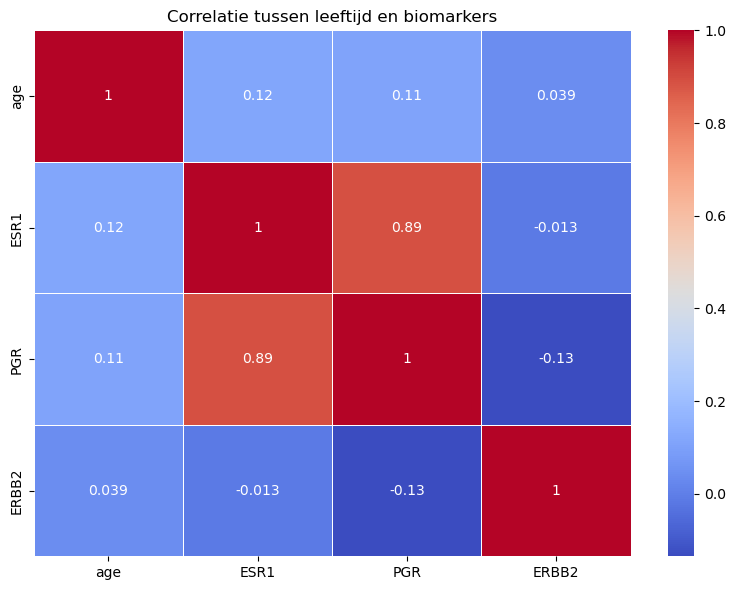

In [175]:
# Selecteer relevante numerieke kolommen
corr_data = df[['age', 'ESR1', 'PGR', 'ERBB2']].copy()

# Correlatiematrix berekenen
corr_matrix = corr_data.corr()

# Plot de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlatie tussen leeftijd en biomarkers")
plt.tight_layout()
plt.show()


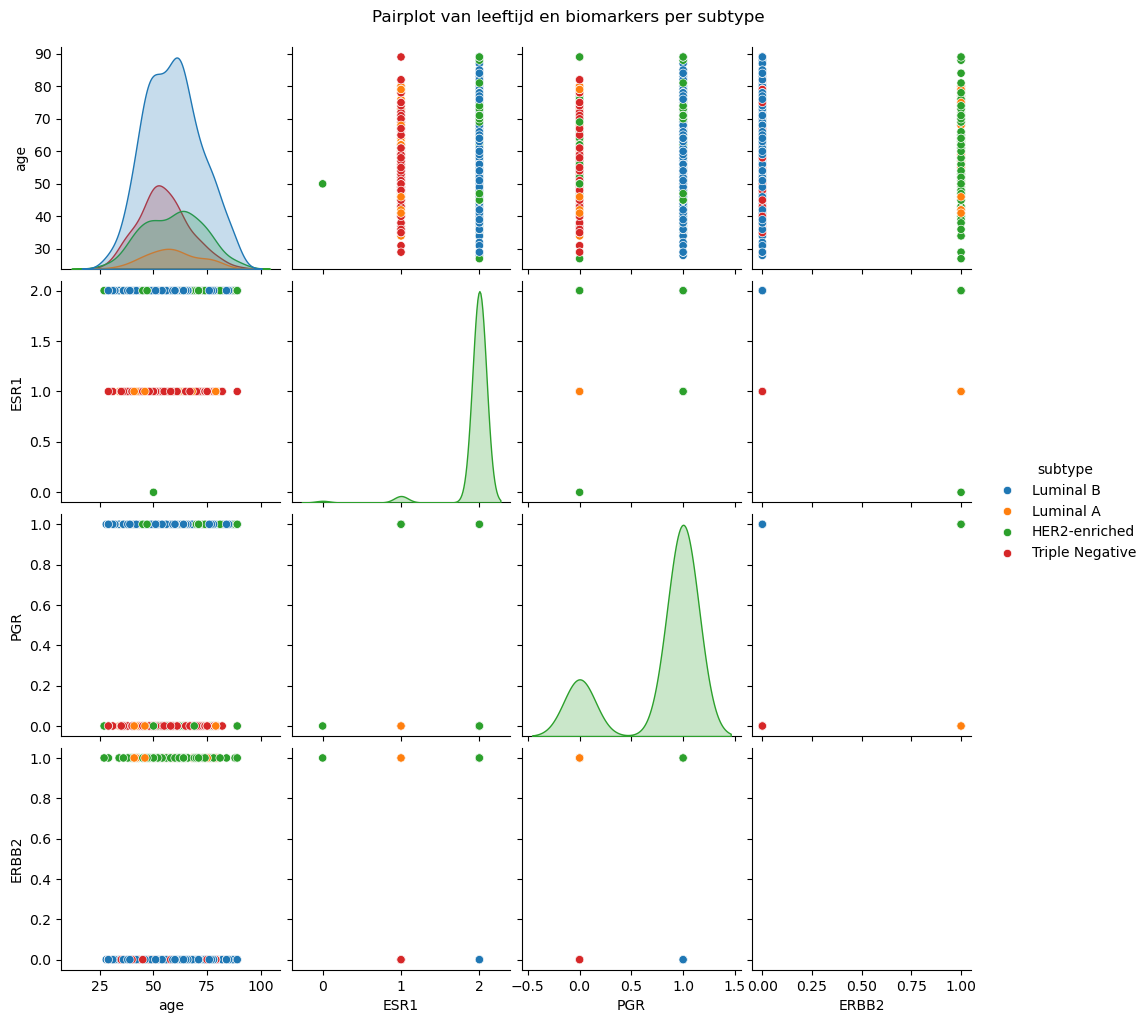

In [176]:
# Zorg dat de kolomnamen kloppen (geen spaties)
df.columns = df.columns.str.strip()

# Pairplot maken met subtype als hue
sns.pairplot(df[['age', 'ESR1', 'PGR', 'ERBB2', 'subtype']], hue='subtype')
plt.suptitle("Pairplot van leeftijd en biomarkers per subtype", y=1.02)
plt.show()
